# MACS30100: Problem Set #3
# Dr. Evans
#
# Name : Dan Gamarnik 
#       
# 


In [63]:
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os

plt.style.use("ggplot")
np.seterr(all='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'ignore', 'under': 'ignore'}

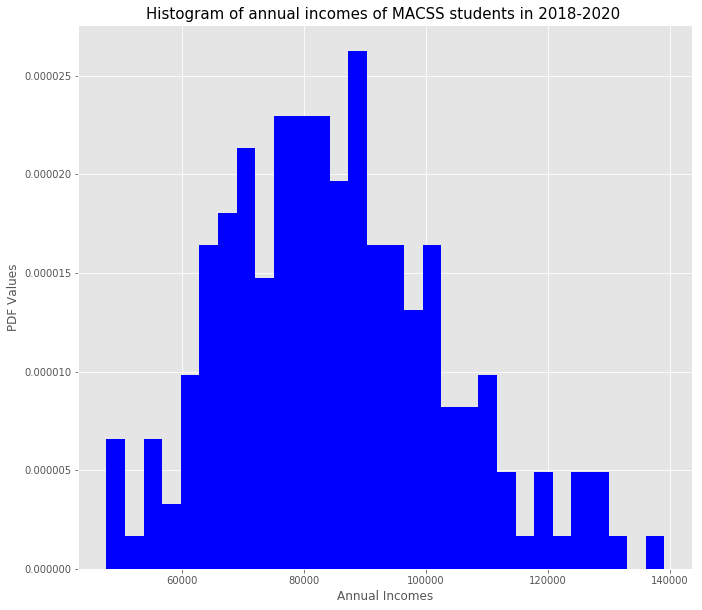

In [64]:
'''
----------------------------------------------------------------------------
Problem 1. Some income data, lognormal distribution, and GMM
----------------------------------------------------------------------------
'''
# load the file
income = np.loadtxt('incomes.txt')

# A).

# plot the histogram
plt.figure(figsize=(11,10))
num_bins = 30 
plt.hist(income, num_bins, normed = True, color = 'blue')
plt.title('Histogram of annual incomes of MACSS students in 2018-2020 ',
             fontsize=15)
plt.xlabel('Annual Incomes')
plt.ylabel('PDF Values')
plt.show()


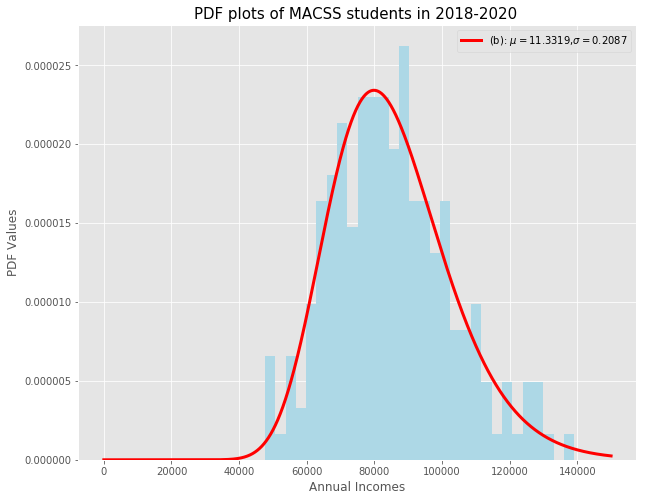


B).
Mu for GMM is 11.331880879622766 standard deviation for GMM is 0.20869665796822717
The value of GMM criterion function at the estimated parameter values is 1.527799636760212e-15
Data moments at the estimated parameter values; Mu is 85276.82360625811 and standard deviation is 17992.542128046523
Model moments at the estimated parameter values; Mu is 85276.82659807919 and standard deviation is 17992.54243809206
Data moments and model moments are very close. We can say that GMM estimates well.


In [65]:
# B).

def trunc_lognorm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate lognormal pdf values from the truncated normal pdf 
    with mean mu and standard deviation sigma. If the cutoff is finite, 
    then the PDF values are inflated upward to reflect the zero probability
    on values above the cutoff. 
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = sts.norm.cdf(cutoff, loc=mu, scale=sigma)
    
    lognorm_pdf_vals = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return lognorm_pdf_vals

def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), standard deviation(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    RETURNS: mean_data, std_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data


def model_moments(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), standard deviation(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    RETURNS: mean_model, std_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cutoff)
    # use small enough figure to lower bound and large enough figure to upper bound
    (mean_model, m_m_err) = intgr.quad(xfx, 0, 15000000) 
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0, 15000000)
    std_model = np.sqrt(var_model)
    s_m_err = np.sqrt(v_m_err)
    
    return mean_model, std_model


def err_vec(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat) # waiting matrix 
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 

    return crit_val

# initial values
mu_init = 11
sig_init = 0.2

# these figures are from PS2 and modify to resonable features
cutoff = 150000
lower_bound = 0.00
upper_bound = 150000
nums = 150000

params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2) # use identity matrix as weighting matrix
gmm_args = (income, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                    method='L-BFGS-B',
                    bounds=((1e-10, None), (1e-10, None)))
# get first estimated parameter with GMM
mu_GMM1, sig_GMM1 = results.x

# get the value of GMM critetion function
params_GMM1 = np.array([mu_GMM1, sig_GMM1])
value1 = criterion(params_GMM1, *gmm_args)[0][0]

# get two data moments and two model moments
mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 150000)

# plot all graph from A). and estimated lognormal PDF graph
# plot the histogram of the data from A).
plt.figure(figsize=(10,8))
num_bins = 30 
plt.hist(income, num_bins, normed = True, color = 'lightblue')
plt.title('PDF plots of MACSS students in 2018-2020 ', fontsize=15)
plt.xlabel('Annual Incomes')
plt.ylabel('PDF Values')

# B). Plot the estimated GMM PDF
dist_income = np.linspace(lower_bound, upper_bound, nums)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1, sig_GMM1, 150000),
         linewidth=3, color='red', label='(b): $\mu = 11.3319 $,$\sigma = 0.2087$')
plt.legend(loc='upper right')
plt.show()


print('')
print('B).')
print('Mu for GMM is {}'.format(mu_GMM1), 'standard deviation for GMM is {}'
    .format(sig_GMM1))
print('The value of GMM criterion function at the estimated parameter values is {}'
    .format(value1))
print('Data moments at the estimated parameter values; Mu is {} and standard deviation is {}'.format(mean_data, std_data))
print('Model moments at the estimated parameter values; Mu is {} and standard deviation is {}'.format(mean_model, std_model))
print('Data moments and model moments are very close. We can say that GMM estimates well.')


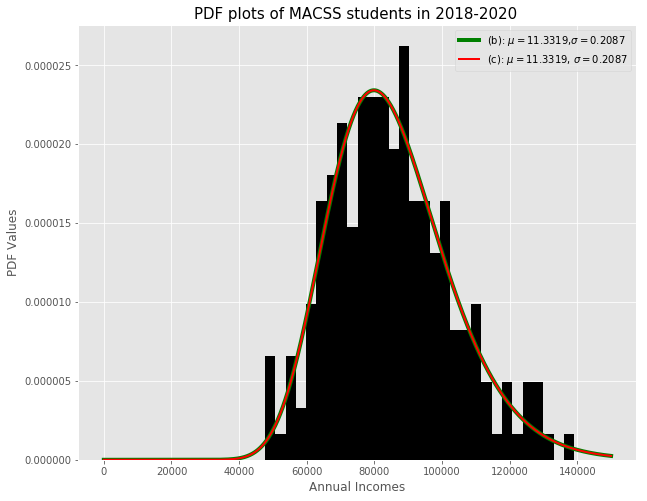


C.
Mu with the two-step GMM extimator is 11.331880875648768 standard deviation with the two-step GMM extimator is 0.20869664411215583
The value of GMM criterion function at the estimated parameter values is 2.7124417650528643e-05
Data moments at the estimated parameter values; Mu is85276.82360625811 and standard deviation is 17992.542128046523
Model moments at the estimated parameter values; Mu is 85276.82601259292 and standard deviation is 17992.541093771666
There are very small differences between data moments and model moments with two-step GMM. We can say that they are very close.


In [66]:
# C). 

# two- step weighting matrix
err1 = err_vec(income, mu_GMM1, sig_GMM1, 150000, False) # error vector 
VCV2 = np.dot(err1, err1.T) / income.shape[0] # variance-covariance vector
W_hat2 = lin.pinv(VCV2)  

# initial value
mu_init = 11.0
sig_init = 0.2
#parames_init = np.array([mu_init, sig_init])
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args2 = (income, 150000, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args2),
                       method='L-BFGS-B', 
                       bounds=((1e-10, None), (1e-10, None)))

# get estimated parameter with two-step GMM
mu_GMM2, sig_GMM2 = results2.x

# get the value of GMM critetion function
params_init_GMM2 = np.array([mu_GMM2, sig_GMM2])
value2 = criterion(params_init_GMM2, *gmm_args2)[0][0]

# get two data moments and two model moments
mean_data2, std_data2 = data_moments(income)
mean_mode2, std_mode2 = model_moments(mu_GMM2, sig_GMM2, 150000)

# plot all graph from A), B) and estimated lognormal PDF graph with two-step GMM
# plot the histogram of the data from A)
plt.figure(figsize=(10,8))
num_bins = 30 
plt.hist(income, num_bins, normed = True, color = 'black')
plt.title('PDF plots of MACSS students in 2018-2020 ', fontsize=15)
plt.xlabel('Annual Incomes')
plt.ylabel('PDF Values')

# plot the estimated GMM PDF from B).
dist_income = np.linspace(lower_bound, upper_bound, nums)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1, sig_GMM1, 150000),
         linewidth=4, color='green', label='(b): $\mu = 11.3319$,$\sigma = 0.2087$')
plt.legend(loc='upper right')

# C). Plot the the estimated GMM2 PDF
dist_income = np.linspace(lower_bound, upper_bound, nums)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM2, sig_GMM2, 150000),
         linewidth=2, color='red', label='(c): $\mu = 11.3319$, $\sigma = 0.2087$')
plt.legend(loc='upper right')
plt.show()

print('')
print('C.')
print('Mu with the two-step GMM extimator is {}'.format(mu_GMM2),
      'standard deviation with the two-step GMM extimator is {}'
      .format(sig_GMM2))
print('The value of GMM criterion function at the estimated parameter values is {}'
      .format(value2))
print('Data moments at the estimated parameter values; Mu is{} and standard deviation is {}'
      .format(mean_data2, std_data2))
print('Model moments at the estimated parameter values; Mu is {} and standard deviation is {}'
      .format(mean_mode2, std_mode2))
print('There are very small differences between data moments and \
model moments with two-step GMM. We can say that they are very close.')


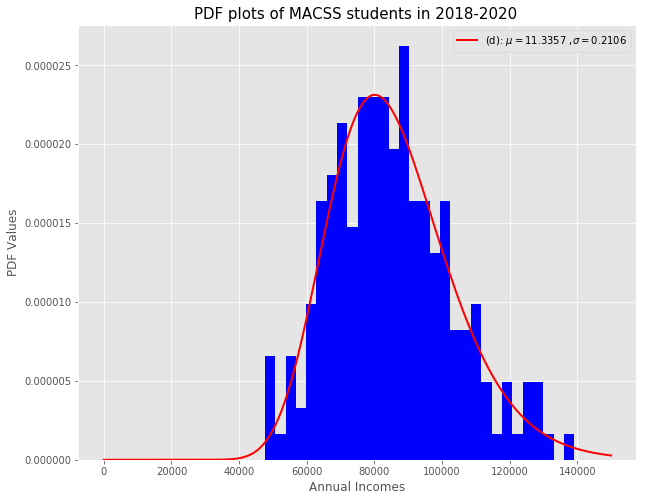


D).
Estimated mu with GMM using three moments is 11.335681500134852
Estimated standard deviation with GMM using three moments is 0.21059989859759912
The value of GMM criterion function at the estimated parameter values is 1.218716526687726e-11
Data moments at the estimated parameter values are: 0.3, 0.5, 0.2
Model moments at the estimated parameter values are: 0.30000096942041676, 0.4999971939215148, 0.20000183665806764
Though we can see there are very little differences between three data momentsagainst three model moments we can say that three model moments are very close to three data moments.


In [67]:
# D).

def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the three data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    RETURNS: bpct_1, bpct_2, bpct_3, bpct_4
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=100000)].shape[0] /
                  xvals.shape[0])
   
    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the three model moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cutoff)
    # use small enough figure to lower bound 
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.00001, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    # use large enough figure to upper bound
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 1500000)  

    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments

    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])

    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff, simple = True)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val

# initial value
mu_init = 11.0
sig_init = 0.2

params_init = np.array([mu_init, sig_init])
W_hat_3d = np.eye(3) # use identity matrix as weighting matrix
gmm_args3 = (income, cutoff, W_hat_3d)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args3),
                       method='TNC', bounds=((1e-10, None), (1e-10, None)))

# get the estimated parameters with GMM by using different moments
mu_GMM1_3, sig_GMM1_3 = results_3.x

# get the value of GMM critetion function
params_init_GMM1_3 = np.array([mu_GMM1_3, sig_GMM1_3])
value3 = criterion3(params_init_GMM1_3, *gmm_args3)[0][0]

# get three data moments and three model moments
data_moment3_1, data_moment3_2, data_moment3_3 = data_moments3(income)
model_moment3_1, model_moment3_2,model_moment3_3 = model_moments3(mu_GMM1_3, sig_GMM1_3, cutoff)


# plot all graph from 1-a and estimated lognormal PDF graph from above
# plot the histogram of the data from  1-a
plt.figure(figsize=(10,8))
num_bins = 30 
plt.hist(income, num_bins, normed = True, color = 'blue')
plt.title('PDF plots of MACSS students in 2018-2020 ', fontsize=15)
plt.xlabel('Annual Incomes')
plt.ylabel('PDF Values')

# 1-d plot the estimated GMM PDF from above
dist_income = np.linspace(lower_bound, upper_bound, nums)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1_3, sig_GMM1_3, 150000),
         linewidth=2, color='red', label='(d): $\mu = 11.3357$ ,$\sigma = 0.2106$')
plt.legend(loc='upper right')
plt.show()

print('')
print('D).')
print('Estimated mu with GMM using three moments is {}'.format(mu_GMM1_3))
print('Estimated standard deviation with GMM using three moments is {}'
    .format(sig_GMM1_3))
print('The value of GMM criterion function at the estimated parameter values is {}'
    .format(value3))
print('Data moments at the estimated parameter values are: {}, {}, {}'
    .format(data_moment3_1, data_moment3_2, data_moment3_3))
print('Model moments at the estimated parameter values are: {}, {}, {}'
    .format(model_moment3_1, model_moment3_2,model_moment3_3))
print('Though we can see there are very little differences between three data moments\
against three model moments we can say that three model moments are very close \
to three data moments.')


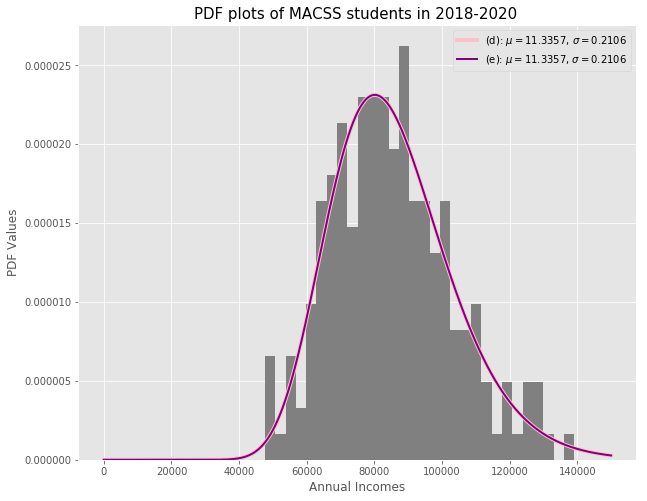


E).
Estimated mu with two step GMM using three moments is 11.335682571476385
Estimated standard deviation with two step GMM using three moments  is 0.21059846880532573
The value of GMM criterion function at the estimated parameter values is 0.0005950032498406449
Data moments at the estimated parameter values are: 0.3, 0.5, 0.2
Model moments at the estimated parameter values are : 0.29999796279868857, 0.5000003760103441, 0.2000016611909666
We can observe that there are very little differences between three data momentsagainst three model moments with two setp GMM. However, we can say thatthree model moments are very close to three data moments.


In [68]:
# E).

# two- step weighting matrix.
err1_3 = err_vec3(income, mu_GMM1_3, sig_GMM1_3, 150000, True)
VCV2_3 = np.dot(err1_3, err1_3.T) / income.shape[0]
W_hat2_3 = lin.pinv(VCV2_3) 

# initial value
mu_init = 11.0
sig_init = 0.2

params_init = np.array([mu_GMM1_3, sig_GMM1_3])
#params_init = np.array([mu_init, sig_init])
gmm_args2_3 = (income, 150000, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args2_3),
                        method='TNC', bounds=((1e-10, None), (1e-10, None)))

# get the estimated parameters with two-step GMM by using different moments
mu_GMM2_3, sig_GMM2_3 = results2_3.x

# get the value of GMM critetion function
params_init2_3 = np.array([mu_GMM2_3, sig_GMM2_3])
value_3e = criterion3(params_init2_3, *gmm_args2_3)[0][0]

# get three data moments and three model moments
data_moment3e_1, data_moment3e_2, data_moment3e_3 = data_moments3(income)
model_moment3e_1, model_moment3e_2,model_moment3e_3 = model_moments3(mu_GMM2_3,
                                                             sig_GMM2_3, 150000)

# plot all graph from 1-a, 1-d and estimated lognormal PDF graph from 1-e
# plot the histogram of the data from 1-a
plt.figure(figsize=(10,8))
num_bins = 30 
plt.hist(income, num_bins, normed = True, color = 'grey')
plt.title('PDF plots of MACSS students in 2018-2020 ', fontsize=15)
plt.xlabel('Annual Incomes')
plt.ylabel('PDF Values')

# Plot the estimated GMM PDF from 1-d
dist_income = np.linspace(lower_bound, upper_bound, nums)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1_3, sig_GMM1_3, 150000),
         linewidth=4, color='pink', label='(d): $\mu = 11.3357$, $\sigma = 0.2106$')
plt.legend(loc='upper right')

# 1-e Plot the estimated GMM PDF
dist_income = np.linspace(lower_bound, upper_bound, nums)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM2_3, sig_GMM2_3, 150000),
         linewidth=2, color='purple', label='(e): $\mu = 11.3357$, $\sigma = 0.2106$')
plt.legend(loc='upper right')
plt.show()

print('')
print('E).')
print('Estimated mu with two step GMM using three moments is {}'.format(mu_GMM2_3))
print('Estimated standard deviation with two step GMM using three moments  is {}'
    .format(sig_GMM2_3))
print('The value of GMM criterion function at the estimated parameter values is {}'
    .format(value_3e))
print('Data moments at the estimated parameter values are: {}, {}, {}'
    .format(data_moment3e_1, data_moment3e_2, data_moment3e_3))
print('Model moments at the estimated parameter values are : {}, {}, {}'
    .format(model_moment3e_1, model_moment3e_2,model_moment3e_3))
print('We can observe that there are very little differences between three data moments\
against three model moments with two setp GMM. However, we can say that\
three model moments are very close to three data moments.')


In [69]:
# F).

print('')
print('F.')
print('Estimation from (e) fits the data best. All four estimations from (b),(c),(d),(e)\
fit well with the given data and are very close estimations. \
In figure 3, (b) and (c) are very close in the plot and also in figure5, (d) and\
(e) are also very close in the plot. It is hard to tell the best estimation when\
you only consider graphs, so we have to consider all possible values derived from\
the data. With comparing the differences between data moments and model moments,\
(c) and (e) both perform better than (b) and (d). Then when we consider the plots,\
(e) covers slightly more in right tail and the data seems to be distributed more \
at the right tail according to the histogram. Thus I can conclude (e) fits the data best.')



F.
Estimation from (e) fits the data best. All four estimations from (b),(c),(d),(e)fit well with the given data and are very close estimations. In figure 3, (b) and (c) are very close in the plot and also in figure5, (d) and(e) are also very close in the plot. It is hard to tell the best estimation whenyou only consider graphs, so we have to consider all possible values derived fromthe data. With comparing the differences between data moments and model moments,(c) and (e) both perform better than (b) and (d). Then when we consider the plots,(e) covers slightly more in right tail and the data seems to be distributed more at the right tail according to the histogram. Thus I can conclude (e) fits the data best.


In [70]:
sick = np.loadtxt('sick.txt', skiprows=1, delimiter=',')



def sick_data_moments(data):
    data_momentsls = []
    for i in range(data.shape[0]):
        data_value = data[i,0]
        data_momentsls.append(data_value)
    return data_momentsls



def sick_model_moments(data, b0, b1, b2, b3):
    model_momentsls = []
    for i in range(data.shape[0]):
        age_i = data[i,1]
        children_i= data[i,2]
        avgtemp_winter_i = data[i,3]
        model_value = b0 + b1 * age_i + b2 * children_i + b3 * avgtemp_winter_i
        model_momentsls.append(model_value)
    return model_momentsls



def sick_err_vec(data, b0, b1, b2, b3):
    sick_values = sick_data_moments(data)
    moms_data = np.array(sick_values)
    expected_values = sick_model_moments(data, b0, b1, b2, b3)
    moms_model = np.array(expected_values)
    err_vec = moms_model - moms_data
    return err_vec



def sick_criterion(params, *args):
    b0,b1,b2,b3 = params
    data, sick_cutoff, W = args
    err = sick_err_vec(data, b0, b1, b2, b3)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val



b0_init, b1_init, b2_init, b3_init = (0.2, 0.2, 0.3, 0.3)



sick_params_init = np.array([b0_init,b1_init,b2_init,b3_init])

sick_bnds = ((None, None),(None, None), (None, None), (None, None))

sick_W_hat = np.eye(200)

sick_args = (sick, np.inf, sick_W_hat) 

sick_results = opt.minimize(sick_criterion, sick_params_init, args=(sick_args),

                       method='L-BFGS-B', bounds=sick_bnds)





b0_GMM, b1_GMM, b2_GMM, b3_GMM = sick_results.x




sick_params_init = np.array([b0_GMM, b1_GMM, b2_GMM, b3_GMM])

value_sick = sick_criterion(sick_params_init, *sick_args)



print('')

print('2. A).') 

print('The GMM for b0 is {},'.format(b0_GMM),\

    'the GMM for b1 is {}, '.format(b1_GMM),\

    'the GMM for b2 is {},'.format(b2_GMM),\

    'the GMM for b3 is {}.'.format(b3_GMM))

print('The Value of criterion function is', value_sick)


2. A).
The GMM for b0 is 0.2516447360763687, the GMM for b1 is 0.012933450921939278,  the GMM for b2 is 0.4005011753984226, the GMM for b3 is -0.009991695558106107.
The Value of criterion function is 0.00182128981703
